In [9]:
# NN packages
import jax
import jax.numpy as jnp
import optax

# Visualization packages
import matplotlib.pyplot as plt

# ML Models
from models.MDOF_LNN import Physical_Damped_LNN, Physical_MLP, Physical_Damped_LNN

# Helper functions
from helpers import save_to_file, create_phys_training_data, plot_S_curves, plot_3DS_curves

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **physical coordinates**.

In [2]:
filename='frequency_step_frequency_'
path='results/phys'
start=10.0
stop=24.0
step=0.2

ml_data = save_to_file(filename=filename, path=path, start=start, stop=stop, step=step, check=False)

Data saved to results/phys/data.pkl
Number of files: 71

---EXAMPLE SHAPES---
pose: (301, 39), vel: (301, 39), acc: (301, 39)
If MODAL: 2 Modes, 301 time steps per 39 points along curve
If PHYSICAL: 301 time steps per 39 points along curve
time: (301, 39), F: (39,), T: (39,), force: (301, 39)


#### Dataset Visualization

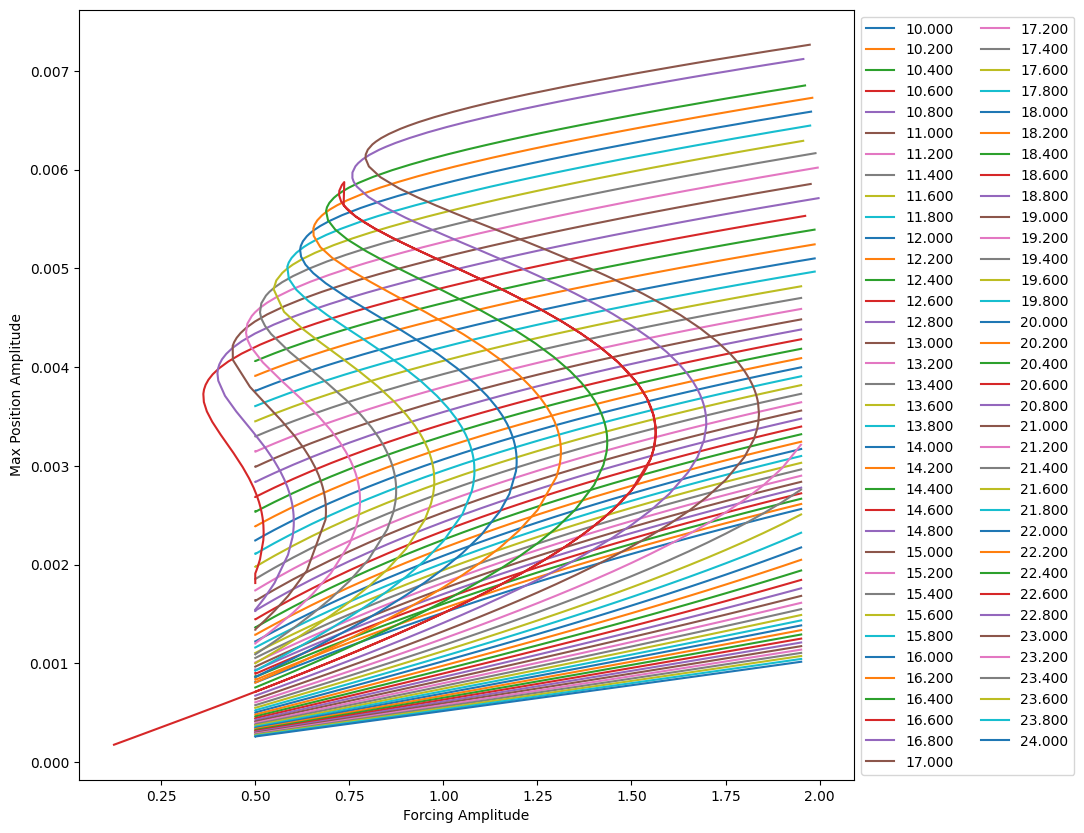

In [3]:
plot_S_curves(ml_data, modal=False)

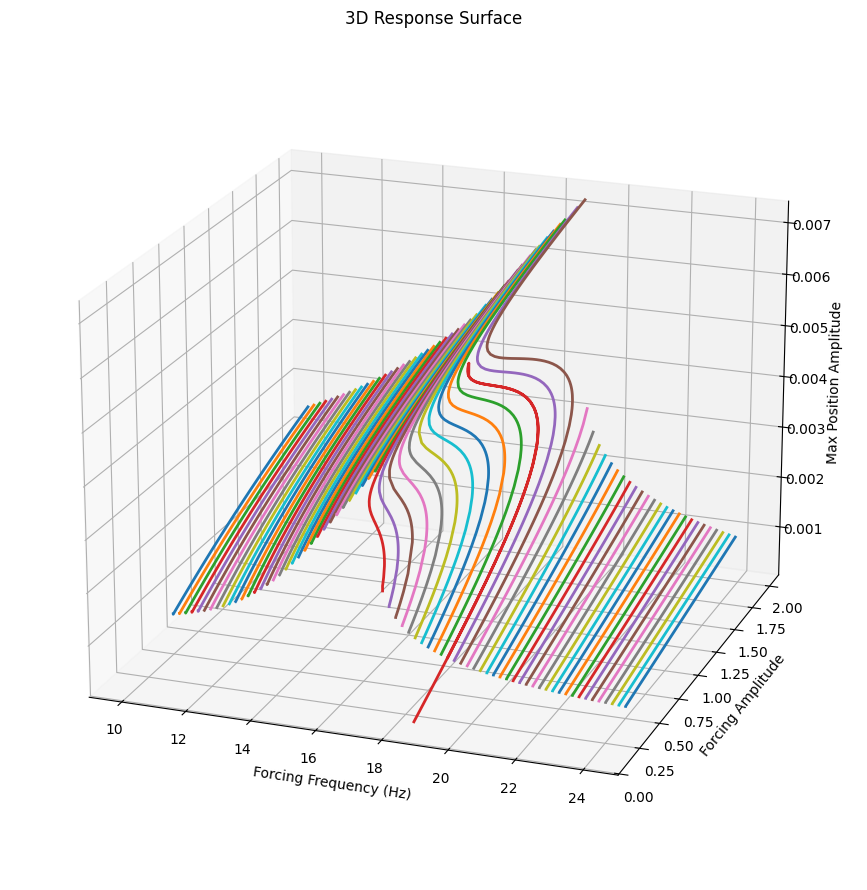

In [4]:
plot_3DS_curves(ml_data, modal=False)

#### LNN Dataset Formation

In [6]:
train_data, test_data, info = create_phys_training_data(ml_data, path, split=0.2, seed=42)

Training data shape: (805175, 4), Testing data shape: (207389, 4)
Samples, [x, dx, ddx, force]
x_train.shape: (805175,), dx_train.shape: (805175,), ddx_train.shape: (805175,), force_train.shape: (805175,)
x_test.shape: (207389,), dx_test.shape: (207389,), ddx_test.shape: (207389,), force_test.shape: (207389,)


In [7]:
# Format dataset for LNN
# Position, velocity & total forcing conditions
train_x = train_data[:, :2] # x, dx
train_dx = train_data[:, 1:3] # dx, ddx
train_f = train_data[:, 3:]

test_x = test_data[:, :2] # x, dx
test_dx = test_data[:, 1:3] # dx, ddx
test_f = test_data[:, 3:]

train_data = train_x, train_f, train_dx
test_data = test_x, test_f, test_dx

In [8]:
train_data[0].shape, test_data[0].shape, train_data[1].shape, test_data[1].shape, train_data[2].shape, test_data[2].shape

((805175, 2), (207389, 2), (805175, 1), (207389, 1), (805175, 2), (207389, 2))

#### LNN


In [12]:
mnn_settings = {
    'name': 'MNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 16,
    'layers': 2,
    'input_shape': 1,
    }

results_path = 'MDOF_LNN'
file_name='Phys'

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [13]:
a = Physical_Damped_LNN(
    mnn_module=Physical_MLP, 
    knn_module=Physical_MLP,       
    dnn_module=Physical_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
results = None
_, _, _ = a.gather()

In [14]:
# Standard loss
for _ in range(20):
    results = a.train(train_data, test_data, results, epochs=epochs, show_every=show_every)
    a.save_model(results, model_name=f"Iter_{results['last_epoch']}", folder_name=f"{results_path}/{file_name}")
print(f"Final loss: {results['best_loss']}")

Epoch: 0 | Train Loss: 44696.87890625 | Best Loss: 17029.18945312 | Test Loss: 17029.18945312
---------------------------------
Epoch: 10 | Train Loss: 23564.86132812 | Best Loss: 31.20111847 | Test Loss: 10906.05664062
---------------------------------
Epoch: 20 | Train Loss: 0.56109995 | Best Loss: 1.15928364 | Test Loss: 1.15928364
---------------------------------
Epoch: 30 | Train Loss: 0.46040693 | Best Loss: 0.93788195 | Test Loss: 0.93788195
---------------------------------
Epoch: 40 | Train Loss: 0.45226485 | Best Loss: 0.92660081 | Test Loss: 0.92660081
---------------------------------
Epoch: 50 | Train Loss: 0.44749546 | Best Loss: 0.92601544 | Test Loss: 0.92601544
---------------------------------
Epoch: 60 | Train Loss: 0.44544256 | Best Loss: 0.92236495 | Test Loss: 0.92236495
---------------------------------
Epoch: 70 | Train Loss: 0.44433558 | Best Loss: 0.92051971 | Test Loss: 0.92051971
---------------------------------
Epoch: 80 | Train Loss: 0.44355506 | Best Lo

In [15]:
def evaluate(results, n_points=40, file_name="MKD"):
        _, pred_energy = a._predict(results)
        limq1, limq2, limqd1, limqd2 = info["qmin"], info["qmax"], info["qdmax"], info["qdmin"]

        qa, qda = jnp.linspace(limq1, limq2, n_points), jnp.linspace(
            limqd1, limqd2, n_points)
        qaa, qdaa = jnp.meshgrid(qa, qda)

        # Get all energy functions here
        M, K, D = pred_energy(qaa.reshape(-1, 1, 1), qdaa.reshape(-1, 1, 1))
        L = M - K

        fig = plt.figure(figsize=(12, 12), tight_layout=True)
        fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

        # --------------------------------- FUNCTIONS

        # -------------------------------- Lagrangian
        ax = fig.add_subplot(221, projection="3d")
        m = ax.plot_surface(qaa, qdaa, L.reshape(qaa.shape), cmap="RdGy", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title(f"Lagrangian")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Mass
        ax = fig.add_subplot(222, projection="3d")
        m = ax.plot_surface(qaa, qdaa, M.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Mass")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Stiffness
        ax = fig.add_subplot(223, projection="3d")
        m = ax.plot_surface(qaa, qdaa, K.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Stiffness")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Damping
        ax = fig.add_subplot(224, projection="3d")
        m = ax.plot_surface(qaa, qdaa, D.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Damping")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
        # fig.savefig(f"./Physical_LNN/{file_name}-LD.png")

        # --------------------------------- ENERGIES --------------------------------- #
        fig = plt.figure(figsize=(10, 10), tight_layout=True)

        # --------------------------------- Stiffness
        K = jax.vmap(jax.jacrev(pred_energy, 0))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[1]
        ax = fig.add_subplot(221)
        ax.plot(qa, -K.squeeze(), lw=0.8)
        ax.set_title("Predicted Spring Force")
        ax.set_xlabel(r"$q \ (m)$", fontsize=12)
        ax.set_ylabel(
            r"$-\frac{\partial \mathcal{L}_{NN}}{\partial q}$", fontsize=18, labelpad=7)

        # ---------------------------------- Damping
        C = jax.vmap(jax.jacrev(pred_energy, 1))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[2]
        ax = fig.add_subplot(222)
        ax.plot(qda, C.squeeze(), lw=0.8)
        ax.set_title("Predicted Damping Force")
        ax.set_ylabel(r"$\dot{q} \ (m \ s^{-1})$ ", fontsize=12)
        ax.set_ylabel(
            r"$\frac{\partial \mathcal{D}_{NN}}{\partial \dot{q}}$", fontsize=18, labelpad=7)

        # ----------------------------------- Mass
        M = jax.vmap(jax.hessian(pred_energy, 1))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[0]
        ax = fig.add_subplot(223)
        m = ax.plot(qa, M.reshape(qda.shape), lw=0.8)
        ax.set_xlabel(r"$q$")
        ax.set_ylabel(
            r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
        ax.set_title(f"Mass")

        ax = fig.add_subplot(224)
        m = ax.plot(qda, M.reshape(qda.shape), lw=0.8)
        ax.set_xlabel(r"$\dot{q}$")
        ax.set_ylabel(
            r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
        ax.set_title(f"Mass")

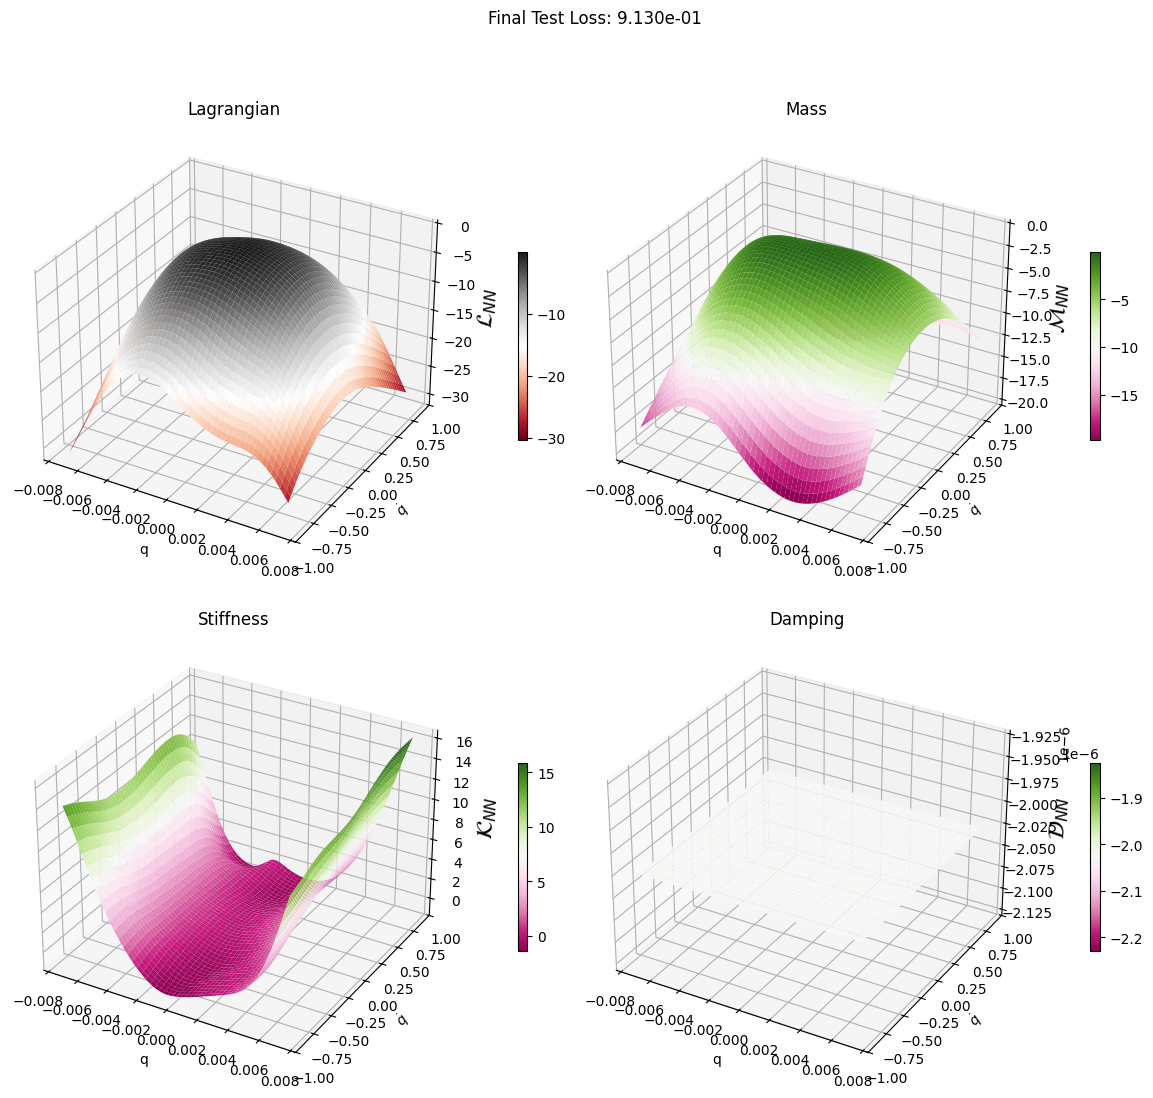

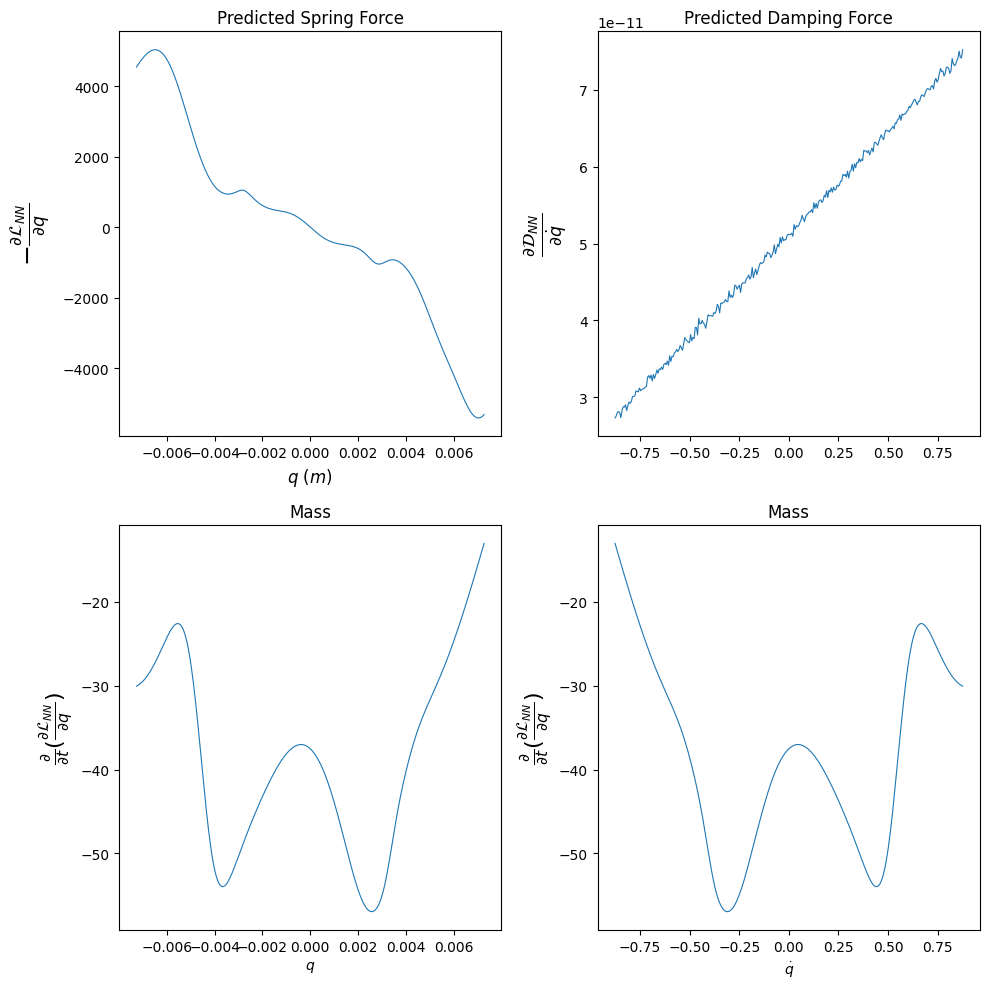

In [16]:
evaluate(results=results, n_points=300, file_name=file_name)